(c) 2023 Manuel Razo. This work is licensed under a [Creative Commons
Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/).
All code contained herein is licensed under an [MIT
license](https://opensource.org/licenses/MIT).

In [1]:
# Load project package
@load_pkg Antibiotic

import Revise
# Import project package
import Antibiotic

# Import package to save outputs
import BSON

# Import package to handle DataFrames
import DataFrames as DF
import CSV
import XLSX

# Import library to list files
import Glob

# Import packages to work with data
import DataFrames as DF

# Import statistical functions
import Random
import StatsBase

# Import basic math
import LinearAlgebra

# Import ML libraries
import Flux
import NNlib
import SimpleChains

# Load CairoMakie for plotting
using CairoMakie
import ColorSchemes
# Activate backend
CairoMakie.activate!()

# Set PBoC Plotting style
Antibiotic.viz.pboc_makie!()

# Exploratory data analysis for Iwasawa et al., 2022 PLoS Comp. Bio.

In this notebook we will explore the resistance dataset from the [PLoS Comp
Bio](https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.3001920)
paper by Iwasawa et al. 2022.

The first thing we will explore is their time-series of resistance data. This is
the data they present on Fig. 1C. We have already turned their data into a tidy
dataframe. Let's load this dataframe.

In [16]:
# Load data into memory
df_ic50 = CSV.read(
    "$(git_root())/data/Iwasawa_2022/iwasawa_ic50_tidy.csv", DF.DataFrame
)

first(df_ic50, 5)

Row,strain,drug,log2ic50,day,ic50_μgmL,parent,env
,String31,String7,Float64?,Int64,Float64?,String7,String7
1,Parent in TET 1,TET,-1.03025,1,0.489626,Parent,TET
2,Parent in TET 1,KM,3.89449,1,14.8716,Parent,TET
3,Parent in TET 1,NFLX,-4.95938,1,0.0321424,Parent,TET
4,Parent in TET 1,SS,6.41736,1,85.4709,Parent,TET
5,Parent in TET 1,PLM,2.82162,1,7.06955,Parent,TET


## SVD on resistance data

As a first pass through the data, let's perform singular value decomposition on
the resistance data. For this, we need to generate a matrix
$\underline{\underline{R}}$ with the resistance values, where each column
corresponds to one of the strains, and each row to each of the stresses.

The dataset has missing values. In particular for a set of **eight** strains,
there were no measurements taken after day 14. There are two ways to perform
this SVD analysis on the data:
1. Ignore these **eight** strains, and use the rest with measurements up to
   day27.
2. Ignore all information after day 14.

The first option sounds more reasonable, as having more days is a more
interesting question.

In [26]:
# Locate strains with missing values
missing_strains = unique(df_ic50[ismissing.(df_ic50.log2ic50), :strain])

# Remove data
df_ic50 = df_ic50[[x ∉ missing_strains for x in df_ic50.strain], :]

first(df_ic50, 5)

Row,strain,drug,log2ic50,day,ic50_μgmL,parent,env
,String31,String7,Float64?,Int64,Float64?,String7,String7
1,Parent in TET 1,KM,3.89449,1,14.8716,Parent,TET
2,Parent in TET 1,MMC,0.532286,1,1.44622,Parent,TET
3,Parent in TET 1,NFLX,-4.95938,1,0.0321424,Parent,TET
4,Parent in TET 1,NQO,0.0939335,1,1.06728,Parent,TET
5,Parent in TET 1,PLM,2.82162,1,7.06955,Parent,TET


In [36]:
# Group data by strain and day
df_group = DF.groupby(df_ic50, [:strain, :day])

# Extract unique drugs to make sure the matrix is built correctly
drug = sort(unique(df_ic50.drug))

# Initialize matrix to save ic50 values
ic50_mat = Matrix{Float32}(undef, length(drug), length(df_group))

# Loop through groups
for (i, data) in enumerate(df_group)
    # Sort data by stress
    DF.sort!(data, :drug)
    # Check that the stress are in the correct order
    if all(data.drug .== drug)
        # Add data to matrix
        ic50_mat[:, i] = Float32.(data.log2ic50)
    else
        println("group $i stress does not match")
    end # if
end # for

# Generate mean-centered matrix
ic50_center = ic50_mat .- StatsBase.mean(ic50_mat, dims=2);

Next, let's compute the singular value decomposition.

In [37]:
# Perform SVD on raw data
U, Σ, V = LinearAlgebra.svd(ic50_mat)

# Perform SVD on mean-centered data
U_center, Σ_center, V_center = LinearAlgebra.svd(ic50_center);

Let's look at the singular value profile.

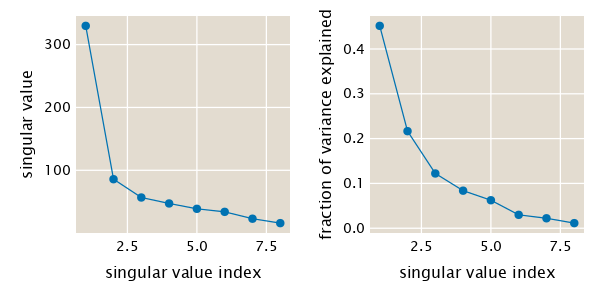

In [38]:
# Initialize figure
fig = Figure(resolution=(600, 300))

# Add axis
ax = Axis(
    fig[1, 1],
    xlabel="singular value index",
    ylabel="singular value",
    # yscale=log10,
)
ax2 = Axis(
    fig[1, 2],
    xlabel="singular value index",
    ylabel="fraction of variance explained",
    # yscale=log10,
)

# Plot singular value spectrum
scatterlines!(ax, Σ)
scatterlines!(ax2, Σ_center .^ 2 ./ sum(Σ_center .^ 2))

fig